# Models A and B results and evaluation

In [1]:
import os

import pickle as pkl
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (15.7, 12.27)

## Generate confusion matrices.

In [2]:
def align_predictions_with_labels(true_entities, predicted_entities):
  """
  Helper function that flattens and aligns the model's predictions
  """
  flattened_true_entities = [y for x in true_entities for y in x]
  flattened_predicted_entities = [y for x in predicted_entities for y in x]
  tags = list(set(flattened_true_entities))
  entities = list(set([e.split('-')[-1] for e in tags]))
  true_tags = [tag for tag in flattened_true_entities]
  true_ents = [tag.split('-')[-1] for tag in flattened_true_entities]
  pred_tags = [tag if tag in tags else 'O' for tag in flattened_predicted_entities]
  pred_ents = [tag.split('-')[-1] if tag.split('-')[-1] in entities else 'O' for tag in
                flattened_predicted_entities]
  return tags, entities, true_tags, pred_tags, true_ents, pred_ents

In [3]:
def generate_confusion_matrix(true_entities, predicted_entities):
  """
  Function that generates the confusion matrices for entities and tags
  """
  tags, entities, true_tags, pred_tags, true_ents, pred_ents = align_predictions_with_labels(
      true_entities=true_entities,
      predicted_entities=predicted_entities)
  ConfusionMatrixDisplay.from_predictions(y_true=true_tags, y_pred=pred_tags, labels=tags, display_labels=tags, xticks_rotation='vertical')
  plt.savefig(fname='./tag_level_confusion_matrix.png', format='png')
  ConfusionMatrixDisplay.from_predictions(y_true=true_ents, y_pred=pred_ents, labels=entities, display_labels=entities, xticks_rotation='vertical')
  plt.savefig(fname='./entity_level_confusion_matrix.png', format='png')

In [4]:
with open("./Model_A/model_outputs.pkl", "rb") as handle:
  modelA = pkl.load(handle)
with open("./Model_B/model_outputs.pkl", "rb") as handle:
  modelB = pkl.load(handle)

## Model **A** confusion matrices for the tag level and the entity level.

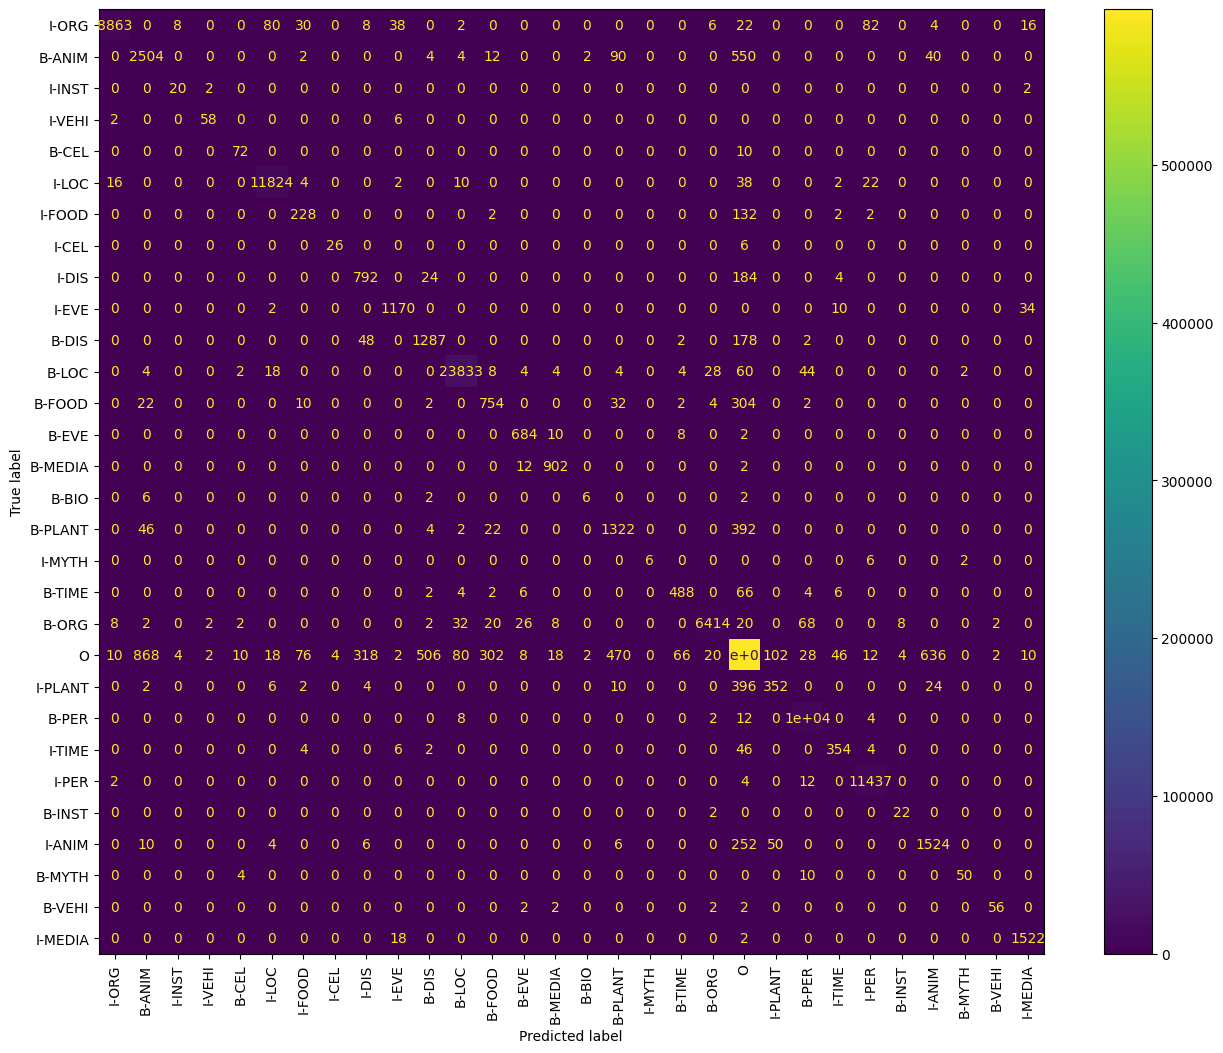

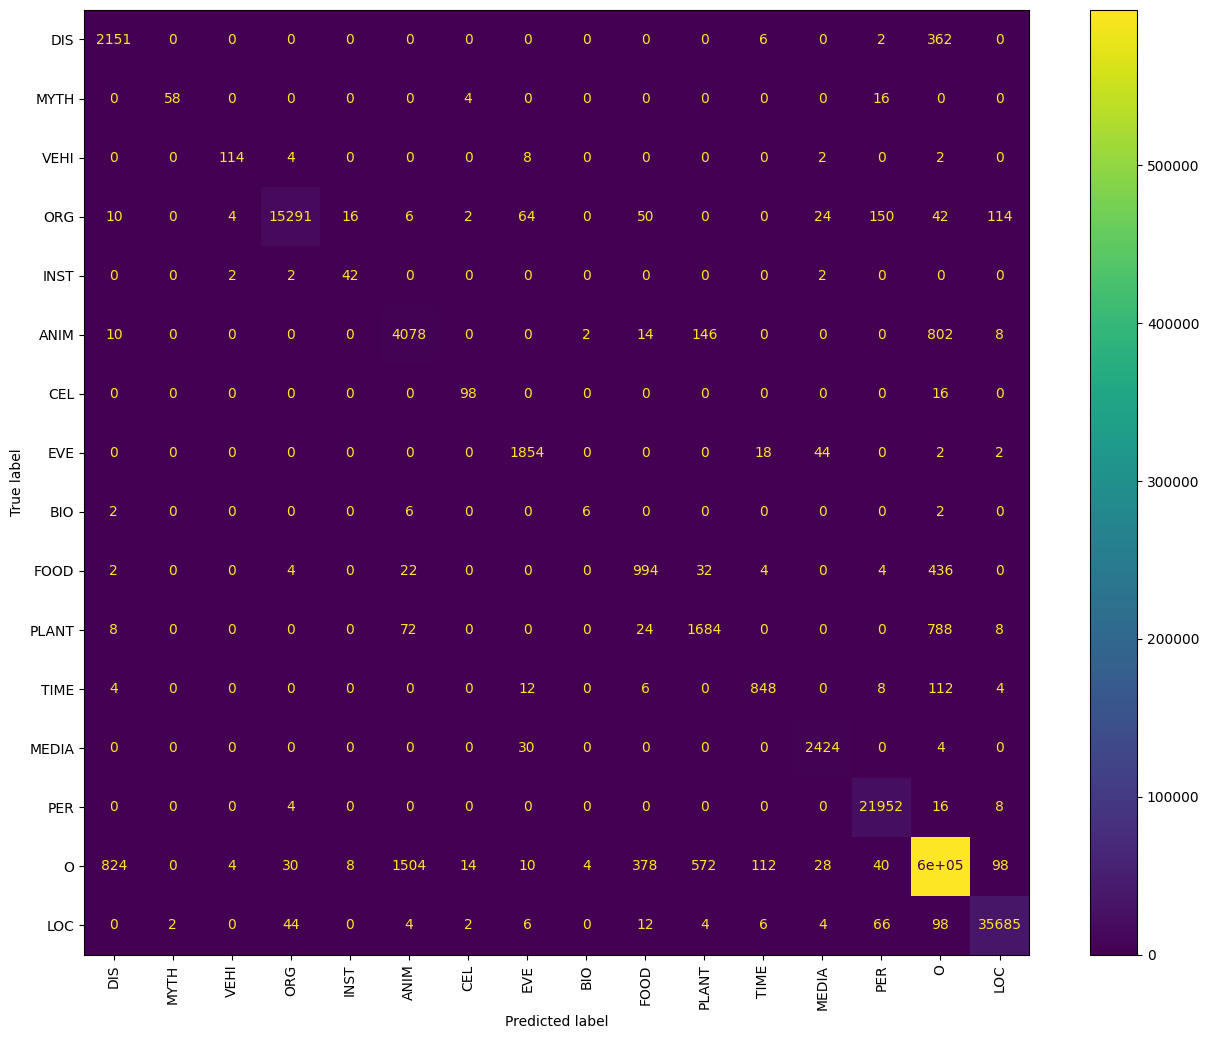

In [5]:
generate_confusion_matrix(true_entities=modelA['labels'], predicted_entities=modelA['predictions'])

## Model **B** confusion matrices for the tag level and the entity level.

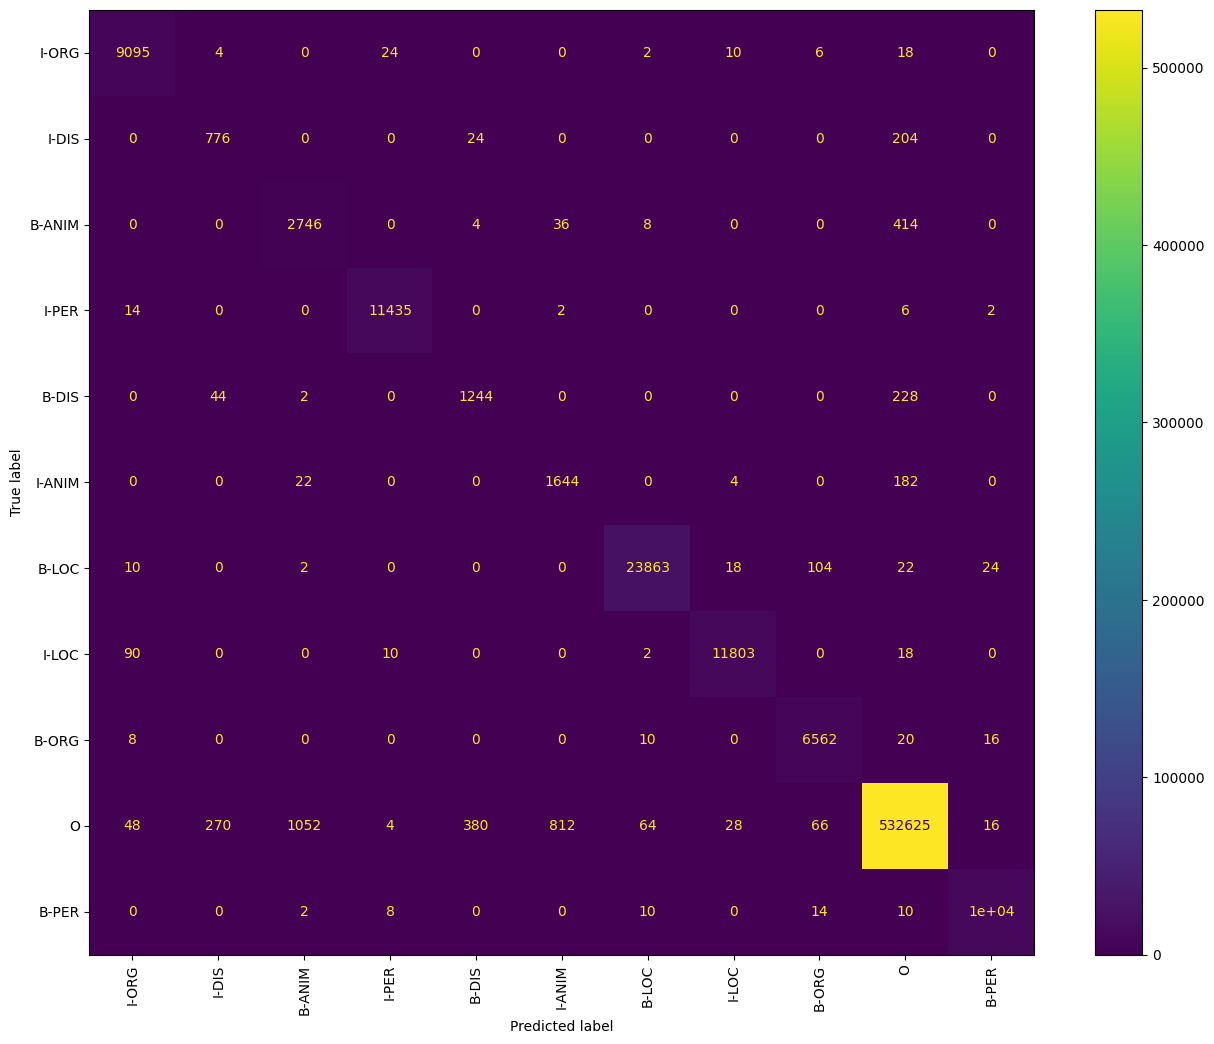

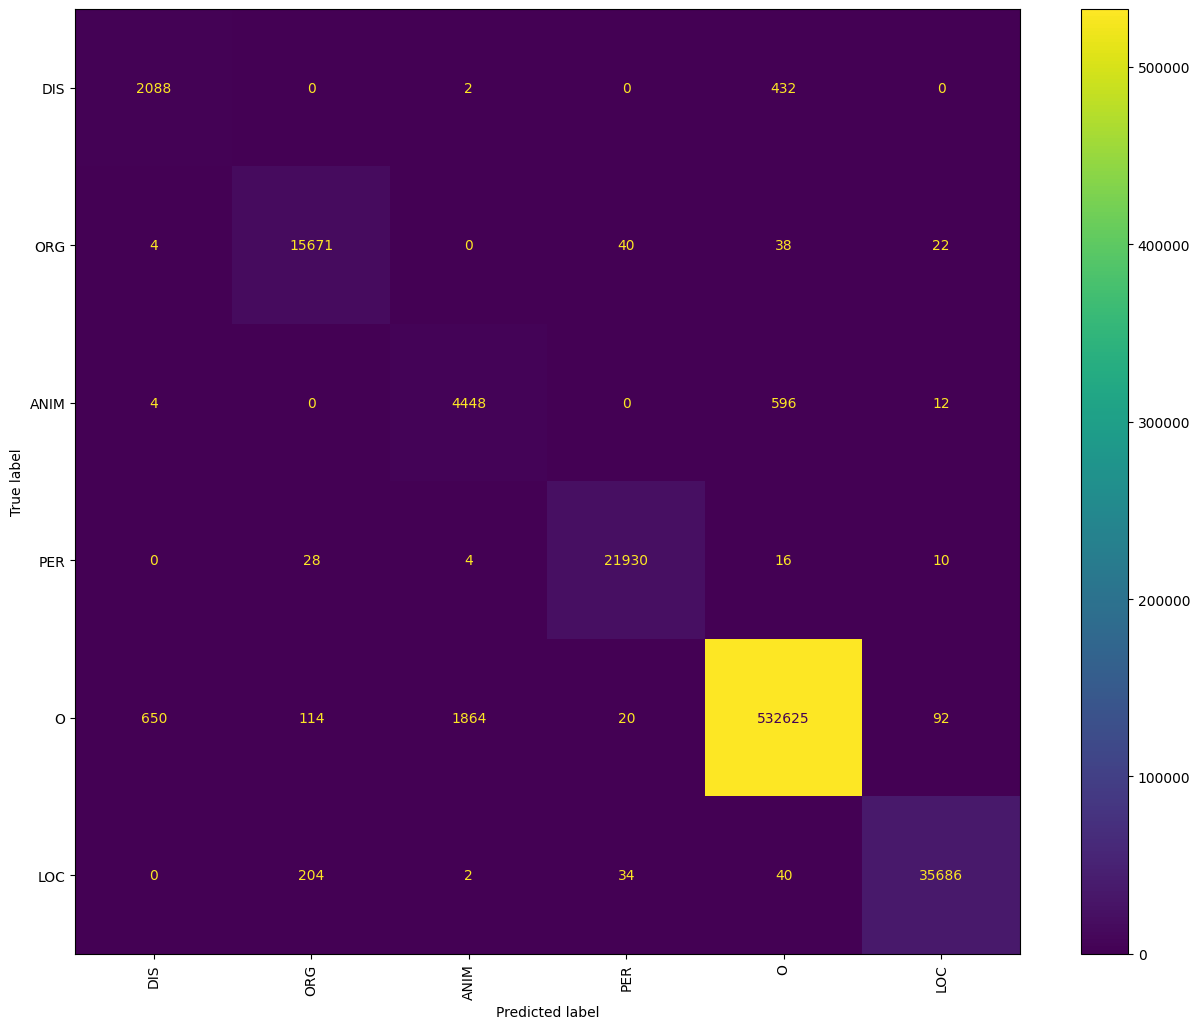

In [6]:
generate_confusion_matrix(true_entities=modelB['labels'], predicted_entities=modelB['predictions'])

## Compute data leakage towards the **"O"** out of scope entites.

In [7]:
def compute_leakage(true_entities, predicted_entities):
  """
  Function that computes the leakage per entity towards the O out of scope
  entities.
  """
  _, _, true_tags, pred_tags, true_ents, pred_ents = align_predictions_with_labels(
      true_entities=true_entities,
      predicted_entities=predicted_entities)
  tag_counts = Counter(true_tags)
  ent_counts = Counter(true_ents)
  true_tag_set = set(true_tags)
  leaked_true_tags = {}
  for tag in true_tag_set:
    leaked_true_tags[tag] = [i for i, j in zip(true_tags, pred_tags) if (j=="O")&(i!="O")&(i==tag)]
    leaked_true_tags[tag] = round(len(leaked_true_tags[tag])/tag_counts[tag], 2)
  leaked_true_tags = {k: v for k, v in sorted(leaked_true_tags.items(), key=lambda item: item[1], reverse=True)}
  true_ents_set = set(true_ents)
  leaked_true_ents = {}
  for ent in true_ents_set:
    leaked_true_ents[ent] = [i for i, j in zip(true_ents, pred_ents) if (j=="O")&(i!="O")&(i==ent)]
    leaked_true_ents[ent] = round(len(leaked_true_ents[ent])/ent_counts[ent], 2)
  leaked_true_ents = {k: v for k, v in sorted(leaked_true_ents.items(), key=lambda item: item[1], reverse=True)}
  return leaked_true_tags, leaked_true_ents

In [8]:
def compute_total_leakage(true_entities, predicted_entities):
  """
  Function that computes the total leakage of named entity parts towards
  the O out of scope entities.
  """
  _, _, true_tags, pred_tags, _, _ = align_predictions_with_labels(
        true_entities=true_entities,
        predicted_entities=predicted_entities)
  leaked_true_tags = [i for i, j in zip(true_tags, pred_tags) if (j=="O")&(i!="O")]
  leaked_true_tags = round(len(leaked_true_tags)/len(true_tags), 5)
  return leaked_true_tags

### Compute total tag leakage towards the **"O"** out of scope entities for both models

In [9]:
# compute the total leakage of tags for each model
modelA_tag_leakage = compute_total_leakage(true_entities=modelA['labels'], predicted_entities=modelA['predictions'])
modelB_tag_leakage = compute_total_leakage(true_entities=modelB['labels'], predicted_entities=modelB['predictions'])
print("Model A data leakage: ", modelA_tag_leakage)
print("Model B data leakage: ", modelB_tag_leakage)

Model A data leakage:  0.00387
Model B data leakage:  0.00182


### Data leakage per tag for Model **A**

In [10]:
# compute the leakage of tags and entities for model A per tag
modelA_tag_leakage, modelA_entity_leakage = compute_leakage(true_entities=modelA['labels'], predicted_entities=modelA['predictions'])
modelA_tag_leakage = pd.DataFrame(modelA_tag_leakage, index=['leakage'])
modelA_tag_leakage = modelA_tag_leakage.loc[:, (modelA_tag_leakage != 0).any(axis=0)]
modelA_tag_leakage

,I-PLANT,I-FOOD,B-FOOD,B-PLANT,I-CEL,I-DIS,B-ANIM,I-ANIM,B-CEL,B-DIS,B-BIO,B-TIME,I-TIME,B-VEHI
leakage,0.5,0.36,0.27,0.22,0.19,0.18,0.17,0.14,0.12,0.12,0.12,0.11,0.11,0.03


### Data leakage per entity for Model **A**

In [11]:
# compute the leakage of tags and entities for model A per entity
modelA_entity_leakage = pd.DataFrame(modelA_entity_leakage, index=['leakage'])
modelA_entity_leakage = modelA_entity_leakage.loc[:, (modelA_entity_leakage != 0).any(axis=0)]
modelA_entity_leakage

,PLANT,FOOD,ANIM,DIS,CEL,BIO,TIME,VEHI
leakage,0.3,0.29,0.16,0.14,0.14,0.12,0.11,0.02


### Data leakage per tag for Model **B**

In [12]:
# compute the leakage of tags and entities for model B per tag
modelB_tag_leakage, modelB_entity_leakage = compute_leakage(true_entities=modelB['labels'], predicted_entities=modelB['predictions'])
modelB_tag_leakage = pd.DataFrame(modelB_tag_leakage, index=['leakage'])
modelB_tag_leakage = modelB_tag_leakage.loc[:, (modelB_tag_leakage != 0).any(axis=0)]
modelB_tag_leakage

,I-DIS,B-DIS,B-ANIM,I-ANIM
leakage,0.2,0.15,0.13,0.1


### Data leakage per entity for Model **B**

In [13]:
# compute the leakage of tags and entities for model B per entity
modelB_entity_leakage = pd.DataFrame(modelB_entity_leakage, index=['leakage'])
modelB_entity_leakage = modelB_entity_leakage.loc[:, (modelB_entity_leakage != 0).any(axis=0)]
modelB_entity_leakage

,DIS,ANIM
leakage,0.17,0.12
